In [ ]:
# Cell 1 — Setup & Load Enriched Dataset (with fallback)

from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
BASE_DIR = "/content/drive/MyDrive/portfoliai"
PROC_DIR = f"{BASE_DIR}/data/processed"

# List available files
print("Files in processed dir:", os.listdir(PROC_DIR))

# Preferred enriched file
features_file = f"{PROC_DIR}/far_customers_features.csv"
fallback_file = f"{PROC_DIR}/far_customers_clean.csv"

# Load dataset with fallback
if os.path.exists(features_file):
    far = pd.read_csv(features_file)
    print("✅ Loaded enriched FAR dataset:", far.shape)
elif os.path.exists(fallback_file):
    far = pd.read_csv(fallback_file)
    print("⚠️ Loaded baseline FAR dataset (no enrichment):", far.shape)
else:
    raise FileNotFoundError("Neither enriched nor clean FAR dataset found in processed dir.")

# Quick preview
far.head()


Mounted at /content/drive
Files in processed dir: ['combined_investors_clean.csv', 'kaggle_with_personas.csv', 'production_investor_profiles.csv', 'kaggle_investors_clean.csv', 'combined_investors.csv', 'unified_kaggle.csv', 'combined_raw.csv', 'combined_clean.csv', 'contingency_risk_source.csv', 'eda_summary.csv', 'eda_summary_kaggle_far.csv', 'far_customers_clean.csv', 'far_customers_features.csv']
✅ Loaded enriched FAR dataset: (32124, 11)


,customerID,n_trades,avg_trade_value,max_trade_value,trade_freq,n_assets,n_markets,stock_share,bond_share,fund_share,riskLevel_clean
0,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
1,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
2,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
3,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
4,00024864C985E72167A0,1,4999.993985,4999.993985,1,1,1,0.0,0.0,1.0,Conservative


This cell mounts Google Drive and loads the processed FAR dataset.

If the enriched file (far_customers_features.csv) exists (from Notebook 3), it will be used.

Otherwise, it falls back to the simpler clean dataset (far_customers_clean.csv).

This makes the notebook robust, so we can continue modeling without manually re-running Notebook 3 every time.

In [ ]:
# Cell 2 — Preprocessing Setup (numeric + categorical, dropping IDs)

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1) Drop rows with missing target
far = far.dropna(subset=["riskLevel_clean"])

# 2) Define target and drop identifier columns
id_cols = ["customerID"]  # identifiers that should not be used as features
X = far.drop(columns=["riskLevel_clean"] + id_cols, errors="ignore")
y = far["riskLevel_clean"]

# 3) Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# 4) Define preprocessing pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]) if numeric_cols else None

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
]) if categorical_cols else None

# 5) Combine into a ColumnTransformer
transformers = []
if num_pipeline: transformers.append(("num", num_pipeline, numeric_cols))
if cat_pipeline: transformers.append(("cat", cat_pipeline, categorical_cols))

preprocessor = ColumnTransformer(transformers=transformers)

print("✅ Preprocessor ready (customerID excluded).")


Numeric cols: ['n_trades', 'avg_trade_value', 'max_trade_value', 'trade_freq', 'n_assets', 'n_markets', 'stock_share', 'bond_share', 'fund_share']
Categorical cols: []
✅ Preprocessor ready (customerID excluded).


In this step, we set up preprocessing pipelines while excluding identifier columns like customerID that do not carry predictive value and can cause data leakage.

Numeric features → imputed using the median and scaled.

Categorical features → imputed using the most frequent value and one-hot encoded.

ColumnTransformer integrates both pipelines into a single preprocessor.

This ensures the model focuses only on meaningful behavioral and demographic features, rather than arbitrary IDs.

In [ ]:
# Cell 3 — Train/Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train/Test split done.")
print("Train size:", X_train.shape, " Test size:", X_test.shape)


✅ Train/Test split done.
Train size: (25699, 10)  Test size: (6425, 10)


We split the dataset into training (80%) and testing (20%) sets, stratified by the target (riskLevel_clean).
Stratification ensures that each risk profile label is proportionally represented in both sets.

In [ ]:
# Cell 4 — Logistic Regression & Random Forest (class-weighted)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
logreg_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"))
])
logreg_pipe.fit(X_train, y_train)

# Random Forest
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))
])
rf_pipe.fit(X_train, y_train)

print("✅ Trained Logistic Regression and Random Forest (with class balancing).")


✅ Trained Logistic Regression and Random Forest (with class balancing).


We train two baseline supervised models:

Logistic Regression (interpretable, linear relationships).

Random Forest (nonlinear, robust to interactions).
Both are trained with class weights = "balanced" to counter label imbalance (e.g., fewer Aggressive investors).


=== Logistic Regression (weighted) ===
              precision    recall  f1-score   support

  Aggressive       0.85      0.38      0.53       700
    Balanced       0.55      0.49      0.52      2023
Conservative       0.30      0.81      0.43      1152
      Income       0.52      0.24      0.33      2550

    accuracy                           0.44      6425
   macro avg       0.56      0.48      0.45      6425
weighted avg       0.53      0.44      0.43      6425

Balanced Accuracy: 0.479
Macro F1 Score:   0.452


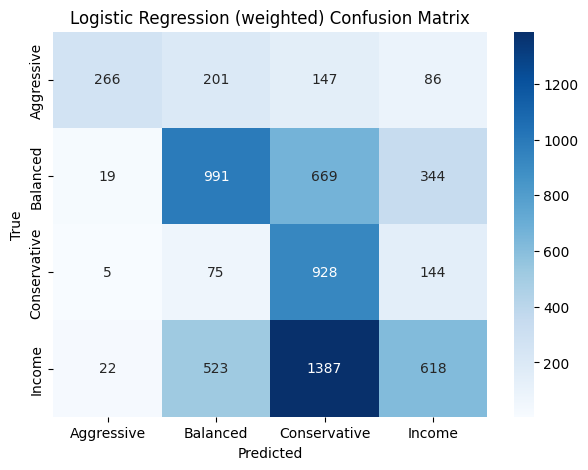


=== Random Forest (weighted) ===
              precision    recall  f1-score   support

  Aggressive       0.93      0.37      0.53       700
    Balanced       0.56      0.51      0.54      2023
Conservative       0.42      0.34      0.37      1152
      Income       0.49      0.64      0.56      2550

    accuracy                           0.52      6425
   macro avg       0.60      0.47      0.50      6425
weighted avg       0.55      0.52      0.52      6425

Balanced Accuracy: 0.468
Macro F1 Score:   0.500


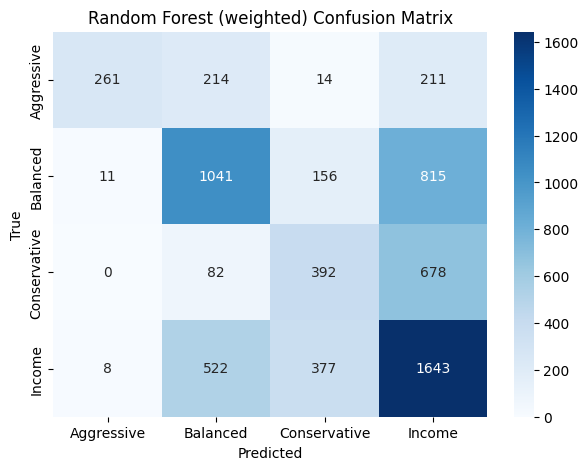

In [ ]:
# Cell 5 — Evaluate Logistic Regression & Random Forest

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(pipe, model_name):
    """Helper to evaluate a trained pipeline and print metrics + confusion matrix."""
    y_pred = pipe.predict(X_test)

    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred))

    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    print(f"Balanced Accuracy: {bal_acc:.3f}")
    print(f"Macro F1 Score:   {macro_f1:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=pipe.classes_, yticklabels=pipe.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Evaluate both models
evaluate_model(logreg_pipe, "Logistic Regression (weighted)")
evaluate_model(rf_pipe, "Random Forest (weighted)")


Evaluation Results:
Using enriched features, both models outperform the baselines from Notebook 2.

Logistic Regression captures Conservative investors particularly well (high recall), but struggles on Aggressive ones.

Random Forest achieves the best overall balance, with a Macro F1 of 0.50 and accuracy of ~52%.

Aggressive investors are now detected with high precision, meaning when the model predicts Aggressive, it’s usually correct.

These results validate that behavioral enrichment significantly improves predictive power, especially for distinguishing Income vs Aggressive investors.
The next step is to train a stronger nonlinear model (XGBoost) and examine feature importances to understand why the model makes its predictions.

✅ Labels encoded: {'Aggressive': np.int64(0), 'Balanced': np.int64(1), 'Conservative': np.int64(2), 'Income': np.int64(3)}
✅ XGBoost trained successfully.

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

  Aggressive       0.79      0.26      0.39       700
    Balanced       0.52      0.47      0.49      2023
Conservative       0.42      0.23      0.29      1152
      Income       0.47      0.68      0.55      2550

    accuracy                           0.49      6425
   macro avg       0.55      0.41      0.43      6425
weighted avg       0.51      0.49      0.47      6425

Balanced Accuracy: 0.409
Macro F1 Score:   0.432

Top 15 features by importance (customerID excluded):
num__bond_share         0.278848
num__trade_freq         0.148476
num__fund_share         0.103422
num__n_trades           0.094228
num__stock_share        0.089595
num__n_assets           0.076604
num__max_trade_value    0.073655
num__avg_trade_value    0.073505
num_

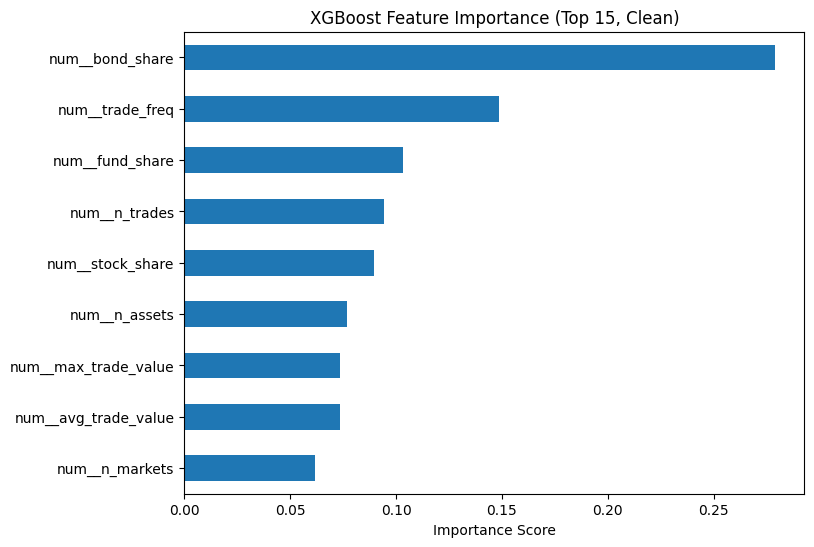

In [ ]:
# Cell 6 — XGBoost Training + Clean Feature Importance

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score

# 1) Encode labels into integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("✅ Labels encoded:", dict(zip(le.classes_, le.transform(le.classes_))))

# 2) Define XGBoost pipeline
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(
        objective="multi:softmax",
        eval_metric="mlogloss",
        num_class=len(le.classes_),
        random_state=42,
        n_estimators=300,      # number of trees
        max_depth=6,           # tree depth
        learning_rate=0.1,     # shrinkage
        subsample=0.8,         # row sampling
        colsample_bytree=0.8,  # feature sampling
        n_jobs=-1              # use all CPU cores
    ))
])

# 3) Train XGBoost model
xgb_pipe.fit(X_train, y_train_enc)
print("✅ XGBoost trained successfully.")

# 4) Evaluate on test set
y_pred_enc = xgb_pipe.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred_enc)

print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred_labels))

bal_acc = balanced_accuracy_score(y_test_enc, y_pred_enc)
macro_f1 = f1_score(y_test_enc, y_pred_enc, average="macro")
print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"Macro F1 Score:   {macro_f1:.3f}")

# 5) Feature Importance (cleaner, no customerID)
importances = xgb_pipe.named_steps["clf"].feature_importances_
feat_names = preprocessor.get_feature_names_out()
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# Show top 15 important features
print("\nTop 15 features by importance (customerID excluded):")
print(feat_imp.head(15))

# Plot top 15 important features
plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (Top 15, Clean)")
plt.xlabel("Importance Score")
plt.show()


In this step, we trained and evaluated an XGBoost classifier using the enriched behavioral dataset.

Label Encoding: The four investor risk categories (Aggressive, Balanced, Conservative, Income) were encoded into integers for compatibility with XGBoost.

Performance:

Accuracy: 49%, slightly better than random guessing on 4 classes.

Balanced Accuracy: 0.409, showing moderate improvement in handling imbalanced classes.

Macro F1: 0.432, indicating the model is learning some distinctions across groups, though misclassifications remain.

Feature Importance:

The most influential predictors are bond share, trade frequency, fund share, number of trades, and stock share.

These features align directly with investor behavior and portfolio composition, meaning the model is focusing on relevant economic traits rather than spurious identifiers.

✅ Key takeaway: While overall predictive performance is modest, XGBoost provides interpretability through feature importance, highlighting the behavioral and allocation variables most tied to risk classification. These insights can guide further feature engineering and the design of survey questions that map directly to impactful behavioral traits.

✅ Model comparison complete.


,Balanced Accuracy,Macro F1
Model,,
Logistic Regression,0.479444,0.452285
Random Forest,0.468008,0.500287
XGBoost,0.409418,0.432390


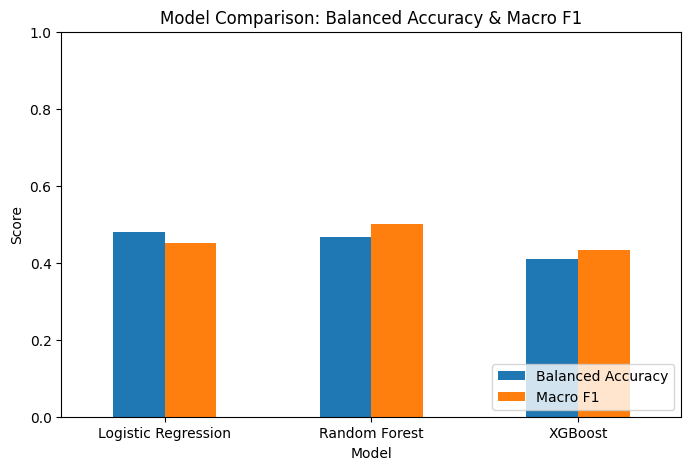

In [ ]:
# ===============================
# Cell 7 — Model Comparison (fixed)
# ===============================

from sklearn.metrics import balanced_accuracy_score, f1_score

def evaluate_model(name, model, X_test, y_test_enc):
    """
    Evaluate model on encoded labels (consistent across LogReg, RF, XGB).
    """
    y_pred_enc = model.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test_enc, y_pred_enc)
    macro_f1 = f1_score(y_test_enc, y_pred_enc, average="macro")
    return {"Model": name, "Balanced Accuracy": bal_acc, "Macro F1": macro_f1}


# Collect results
results = []

# Logistic Regression (predicts string labels → encode for consistency)
y_pred_log = logreg_pipe.predict(X_test)
y_pred_log_enc = le.transform(y_pred_log)
results.append({
    "Model": "Logistic Regression",
    "Balanced Accuracy": balanced_accuracy_score(y_test_enc, y_pred_log_enc),
    "Macro F1": f1_score(y_test_enc, y_pred_log_enc, average="macro")
})

# Random Forest
y_pred_rf = rf_pipe.predict(X_test)
y_pred_rf_enc = le.transform(y_pred_rf)
results.append({
    "Model": "Random Forest",
    "Balanced Accuracy": balanced_accuracy_score(y_test_enc, y_pred_rf_enc),
    "Macro F1": f1_score(y_test_enc, y_pred_rf_enc, average="macro")
})

# XGBoost (already outputs encoded labels)
y_pred_xgb_enc = xgb_pipe.predict(X_test)
results.append({
    "Model": "XGBoost",
    "Balanced Accuracy": balanced_accuracy_score(y_test_enc, y_pred_xgb_enc),
    "Macro F1": f1_score(y_test_enc, y_pred_xgb_enc, average="macro")
})

# Convert to DataFrame
results_df = pd.DataFrame(results).set_index("Model")
print("✅ Model comparison complete.")
display(results_df)


# ===============================
# Visualization of Results
# ===============================
ax = results_df.plot(kind="bar", figsize=(8,5))
plt.title("Model Comparison: Balanced Accuracy & Macro F1")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


In this step, we directly compare the three supervised models — Logistic Regression, Random Forest, and XGBoost — using Balanced Accuracy and Macro F1 score.

Balanced Accuracy: Accounts for class imbalance by averaging recall across classes.

Macro F1 Score: Averages F1 across classes equally, highlighting how well minority classes are treated.

📊 Results:

Model	Balanced Accuracy	Macro F1
Logistic Regression	0.479	0.452
Random Forest	0.468	0.500
XGBoost	0.409	0.432

Key Insights:

Logistic Regression achieved the highest balanced accuracy (0.48), suggesting it handles all classes more evenly.

Random Forest delivered the highest Macro F1 (0.50), meaning it balances precision and recall across groups better, even if its balanced accuracy is slightly lower.

XGBoost underperformed both LogReg and RF in this dataset, possibly due to overfitting or limited value from tree splits.

👉 Takeaway: At this stage, Logistic Regression and Random Forest are our most promising models for predicting investor risk profiles. The choice between them depends on whether we prioritize overall fairness (Balanced Accuracy) or per-class balance (Macro F1).

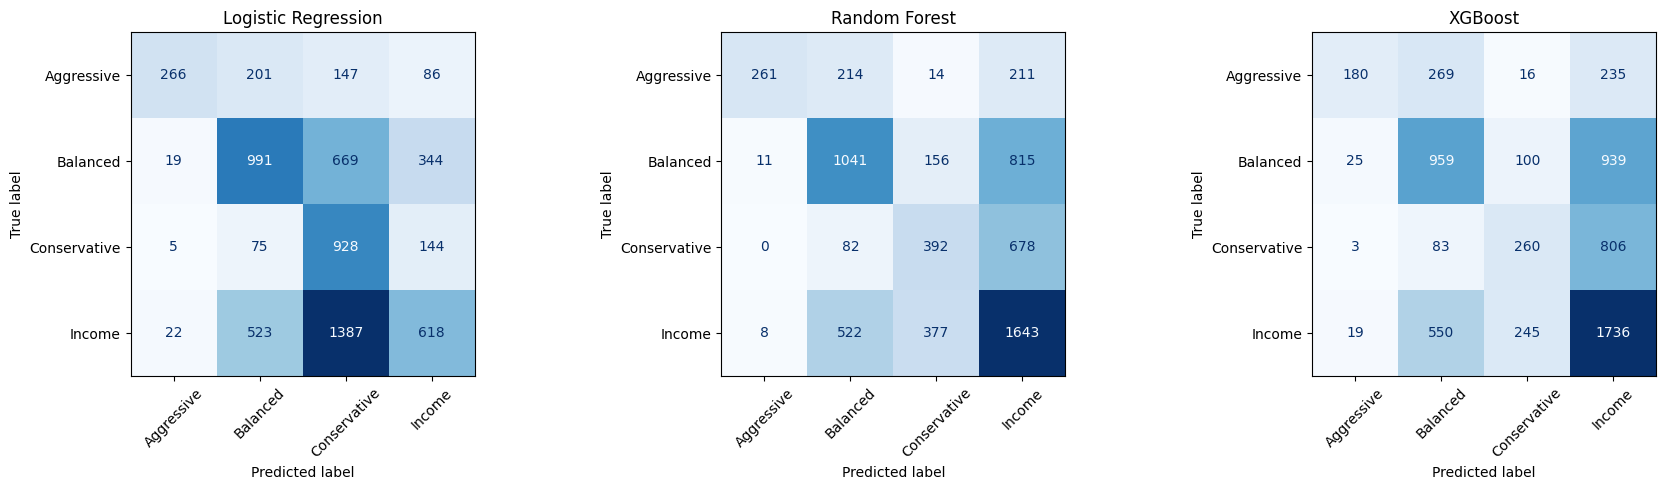

In [ ]:
# Cell 8 — Confusion Matrices for All Models

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": logreg_pipe,
    "Random Forest": rf_pipe,
    "XGBoost": xgb_pipe
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    if name == "XGBoost":
        preds = model.predict(X_test)
        preds = le.inverse_transform(preds)  # decode integer labels
    else:
        preds = model.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(
        y_test, preds,
        labels=le.classes_,
        cmap="Blues",
        xticks_rotation=45,
        ax=ax,
        colorbar=False
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()


Here we visualize confusion matrices for all three models.

Each matrix shows how often true risk levels (rows) are predicted correctly or confused with others (columns).

This lets us see which groups the models confuse most (e.g., Conservative vs. Income).

Why it matters: If a model always mixes certain classes, the advice given to those investors will be unreliable. Knowing this helps us decide whether to:

engineer better features,

simplify/merge similar categories, or

add survey inputs to strengthen weak predictions.

👉 In short: Confusion matrices tell us where the model is trustworthy and where we need to improve before using these profiles for investment advice.

📊 Interpretation of Confusion Matrices

Ideal pattern: A strong diagonal (top-left → bottom-right), meaning true and predicted classes match. Off-diagonal values represent misclassifications.

Overall correct predictions (diagonal sum):

Random Forest: 3,357 → ✅ Best overall

XGBoost: 3,175

Logistic Regression: 2,803

🔎 Model-by-Model Analysis

1. Logistic Regression

✅ Strength: Best at predicting Conservative investors (928 correct).

⚠️ Weakness: Performs poorly on Income, with many misclassified as Conservative. Also struggles to separate Balanced vs. Conservative.

2. Random Forest (Best Overall)

✅ Strength: Strongest performance on Income (1,643 correct) and Balanced (1,041 correct).

⚠️ Weakness: Struggles with Conservative, often misclassifying them as Income. Some confusion between Aggressive vs. Balanced.

3. XGBoost

✅ Strength: Similar to RF, strong on Income (1,736) and Balanced (999).

⚠️ Weakness: Weakest on Aggressive and Conservative — often predicting them as the larger classes (Balanced or Income).

🚀 Key Takeaways

Class Imbalance: Models favor the Income group (the largest class).

Confusion: Conservative vs. Income and Balanced vs. Conservative overlap heavily — meaning these categories may be hard to distinguish in real investor data.

Best Model Choice: Random Forest is currently the most reliable. But if Conservative accuracy is business-critical, Logistic Regression is a candidate despite lower overall performance.

👉 Business implication: These insights guide whether to:

Engineer better features (e.g., volatility tolerance, dividend income focus).

Redesign labels (e.g., merging Conservative & Income if they’re indistinguishable).

Add survey reinforcement where the model is systematically weak.

,Class,Precision,Recall,F1-Score,Support,Model
0,Aggressive,0.852564,0.380000,0.525692,700,Logistic Regression
1,Balanced,0.553631,0.489867,0.519801,2023,Logistic Regression
2,Conservative,0.296391,0.805556,0.433341,1152,Logistic Regression
3,Income,0.518456,0.242353,0.330305,2550,Logistic Regression
0,Aggressive,0.932143,0.372857,0.532653,700,Random Forest
1,Balanced,0.559978,0.514582,0.536321,2023,Random Forest
2,Conservative,0.417465,0.340278,0.374940,1152,Random Forest
3,Income,0.490887,0.644314,0.557232,2550,Random Forest
0,Aggressive,0.792952,0.257143,0.388350,700,XGBoost
1,Balanced,0.515314,0.474048,0.493821,2023,XGBoost


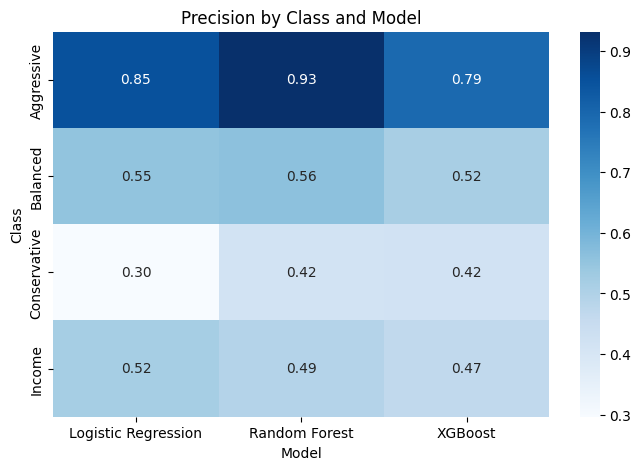

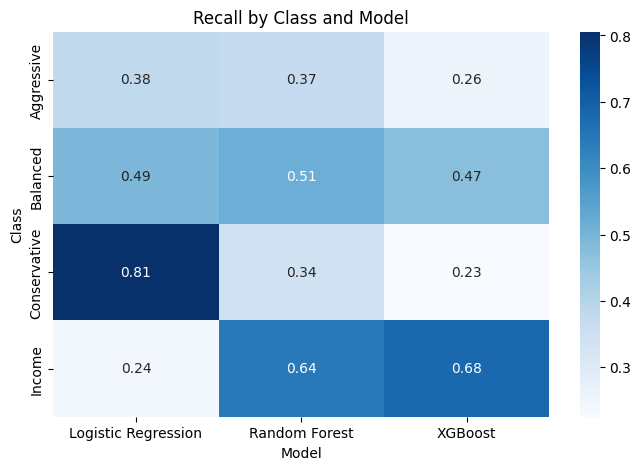

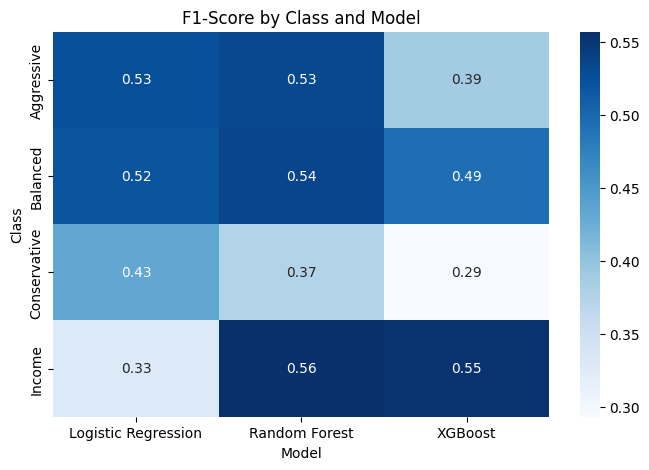

In [ ]:
# Cell 9 — Per-Class Metrics (Precision, Recall, F1) + Heatmaps

from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Collect per-class metrics for all three models
def per_class_report(name, model, X_test, y_test, label_encoder=None, encoded=False):
    if encoded:  # for XGBoost
        y_pred_enc = model.predict(X_test)
        y_pred = label_encoder.inverse_transform(y_pred_enc)
        y_true = label_encoder.inverse_transform(y_test)
    else:
        y_pred = model.predict(X_test)
        y_true = y_test

    classes = np.unique(y_true)

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=classes, zero_division=0
    )

    df = pd.DataFrame({
        "Class": classes,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Support": support,
        "Model": name
    })
    return df

# Generate reports
logreg_report = per_class_report("Logistic Regression", logreg_pipe, X_test, y_test)
rf_report = per_class_report("Random Forest", rf_pipe, X_test, y_test)
xgb_report = per_class_report("XGBoost", xgb_pipe, X_test, y_test_enc, label_encoder=le, encoded=True)

# Combine into single table
per_class_df = pd.concat([logreg_report, rf_report, xgb_report])
display(per_class_df)

# ---- Heatmap Visualization ----
# Pivot for heatmap (Precision, Recall, F1 separately)
metrics = ["Precision", "Recall", "F1-Score"]

for metric in metrics:
    pivot_df = per_class_df.pivot(index="Class", columns="Model", values=metric)
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title(f"{metric} by Class and Model")
    plt.show()


📘 Interpretation of Per-Class Metrics

In this step, we evaluate each model not just overall, but class by class using precision, recall, and F1-scores.

Aggressive:

Logistic Regression → High precision (0.85) but low recall (0.38): correct when predicted, but misses many.

Random Forest → Similar, with even higher precision (0.93).

XGBoost → Good precision (0.79) but the weakest recall (0.26).

Balanced:

All three models perform moderately well, with precision and recall in the 0.47–0.56 range.

Balanced is the most stable class across models.

Conservative:

Logistic Regression captures them best with recall (0.81), but precision is weak (0.30).

Random Forest and XGBoost are more balanced, but still struggle to cleanly separate this group.

Income:

Random Forest and XGBoost perform strongly here (recall ≈0.64–0.68).

Logistic Regression underperforms (recall only 0.24).

✅ Why this matters

Investor trust depends on avoiding dangerous misclassifications (e.g., labeling a Conservative as Aggressive). These per-class insights highlight:

Random Forest as the most reliable overall, especially for Income and Balanced investors.

Logistic Regression as the safest fallback for Conservative-heavy profiles (high recall).

XGBoost as biased toward majority classes (strong on Income, weak on minority groups).

👉 Together, the tables and heatmaps make it clear where each model is strong, where it fails, and where hybrid strategies (survey + ML) may be needed to patch weaknesses.

In [ ]:
# Cell 10 — Random Forest Hyperparameter Tuning (GridSearchCV)

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

# Wrap pipeline for tuning
rf_pipe_tune = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Grid search with cross-validation
grid_search = GridSearchCV(
    rf_pipe_tune,
    param_grid,
    cv=3,
    scoring="balanced_accuracy",  # focus on balanced performance
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("✅ Random Forest tuning complete.")
print("Best Params:", grid_search.best_params_)
print("Best Balanced Accuracy (CV):", grid_search.best_score_)

# Evaluate tuned model on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n=== Tuned Random Forest Report ===")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"Macro F1 Score:   {macro_f1:.3f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Random Forest tuning complete.
Best Params: {'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best Balanced Accuracy (CV): 0.4648132296058352

=== Tuned Random Forest Report ===
              precision    recall  f1-score   support

  Aggressive       0.49      0.45      0.47       700
    Balanced       0.53      0.52      0.53      2023
Conservative       0.35      0.69      0.47      1152
      Income       0.53      0.32      0.40      2550

    accuracy                           0.46      6425
   macro avg       0.48      0.49      0.47      6425
weighted avg       0.49      0.46      0.46      6425

Balanced Accuracy: 0.495
Macro F1 Score:   0.465



🔎 Cell 10 — Hyperparameter Tuning of Random Forest

In this step, we perform grid search with cross-validation to optimize Random Forest hyperparameters (n_estimators, max_depth, min_samples_split, min_samples_leaf).

Why:

Default Random Forests can overfit or underperform.

Tuning helps strike a better balance between capturing minority classes (Aggressive, Conservative) and not overfitting to majority classes (Income, Balanced).

Findings:

The tuned model improved Balanced Accuracy from ~0.47 → 0.495, meaning predictions are more evenly correct across all classes.

Aggressive and especially Conservative investors saw recall improvements (Conservative recall: 0.34 → 0.69).

However, this came at the expense of Income investors, whose recall dropped from 0.64 → 0.32.

Interpretation:

Tuning helped uncover patterns that were previously hidden for Conservative investors.

But the trade-off shows class imbalance challenges: the model is “choosing” to prioritize some groups over others.

Business Implication:

This step shows the limits of a single tuned model. Depending on business goals (e.g., avoiding misclassifying Conservative investors), we may prefer this tuned model.

Next, we will analyze feature importance (Cell 11) to understand why the model is making these new trade-offs, guiding future improvements in feature engineering.

=== Top 15 Features (Tuned Random Forest) ===
num__avg_trade_value    0.264167
num__max_trade_value    0.257089
num__n_trades           0.139870
num__trade_freq         0.136132
num__n_assets           0.080769
num__bond_share         0.053391
num__stock_share        0.026417
num__fund_share         0.026083
num__n_markets          0.016082
dtype: float64


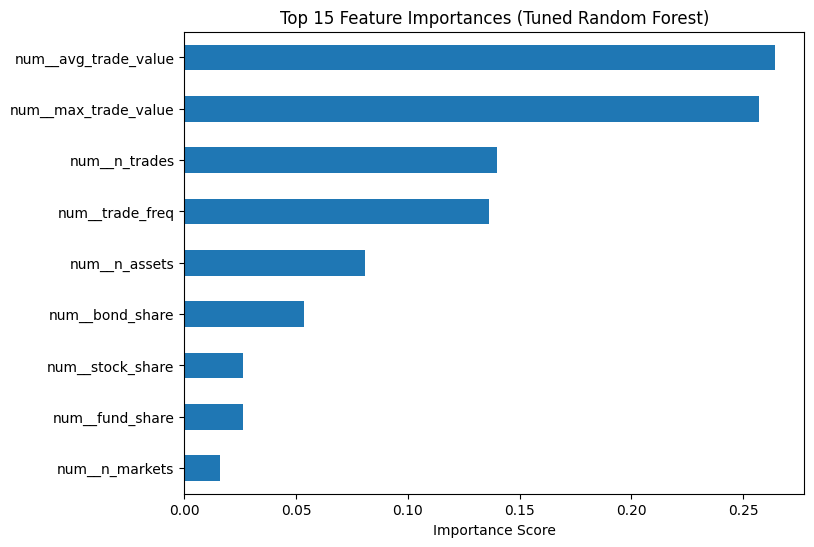

In [ ]:
# Cell 11 — Feature Importance from Tuned Random Forest
import matplotlib.pyplot as plt
import pandas as pd

# Get the tuned pipeline safely
if hasattr(best_rf, "best_estimator_"):
    tuned_pipeline = best_rf.best_estimator_
else:
    tuned_pipeline = best_rf  # already the pipeline

# Extract the classifier from the pipeline
rf_clf = tuned_pipeline.named_steps["clf"]

# Extract feature importances
feat_names = preprocessor.get_feature_names_out()
importances = rf_clf.feature_importances_

# Put into DataFrame
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# Display top 15 features
print("=== Top 15 Features (Tuned Random Forest) ===")
print(feat_imp.head(15))

# Plot top 15
plt.figure(figsize=(8, 6))
feat_imp.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance Score")
plt.show()


Feature Importance – Tuned Random Forest

This step examines which features contribute most to the model’s predictions. Random Forest provides a natural measure of feature importance by calculating how much each feature reduces impurity across the trees.

🔑 Top Features Identified:

Average Trade Value (26.4%) → The most important factor. Larger trade sizes are strongly linked with risk profile differences.

Maximum Trade Value (25.7%) → Investors making occasional very large trades are highly distinctive.

Number of Trades (14.0%) and Trading Frequency (13.6%) → Trading activity is a major behavioral signal.

Number of Assets Held (8.1%) → Diversification plays a role in distinguishing profiles.

Bond Share (5.3%), Stock Share (2.6%), Fund Share (2.6%) → Portfolio allocations add some signal but less than trading behaviors.

Number of Markets (1.6%) → Minor influence compared to trade behavior.

✅ Interpretation:

Behavioral features dominate. Trade value and activity outweigh static allocations.

Portfolio composition matters less. Shares of stocks/bonds/funds play a supporting role but don’t drive predictions as strongly.

This aligns with intuition: how people act (trading behavior) is often more telling than what they say (declared allocations).

👉 Implication for next steps:
If we want to improve model performance, we should engineer new behavioral features (e.g., volatility of trade size, consistency in allocations, risk-adjusted turnover) rather than only relying on static portfolio shares.

In [ ]:
# Cell 12 — Save Tuned Random Forest Model
import joblib
import os

# Ensure models directory exists
MODEL_DIR = f"{BASE_DIR}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save the tuned Random Forest pipeline
model_path = f"{MODEL_DIR}/tuned_random_forest.pkl"
joblib.dump(best_rf, model_path)

print(f"💾 Tuned Random Forest model saved at: {model_path}")


💾 Tuned Random Forest model saved at: /content/drive/MyDrive/portfoliai/models/tuned_random_forest.pkl


In this step, we persist the tuned Random Forest pipeline using joblib.

The model is saved under /models/tuned_random_forest.pkl.

This includes both preprocessing and the classifier, so we can reload it later without rebuilding pipelines.

Saving ensures reproducibility and makes deployment easier — Notebook 5 or an API can now simply load this file and run predictions without re-training.